In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

import models.graph_nn as grap

In [2]:
%load_ext autoreload
%autoreload 2

# data preprocessing

In [67]:
def normalize_features(particles):
    idx_pt, idx_eta, idx_phi, idx_class = range(4)
    # min-max normalize pt
    particles[:,:,idx_pt] = (particles[:,:,idx_pt] - np.min(particles[:,:,idx_pt])) / (np.max(particles[:,:,idx_pt])-np.min(particles[:,:,idx_pt]))
    # standard normalize angles
    particles[:,:,idx_eta] = (particles[:,:,idx_eta] - np.mean(particles[:,:,idx_eta]))/np.std(particles[:,:,idx_eta])
    particles[:,:,idx_eta] = (particles[:,:,idx_eta] - np.mean(particles[:,:,idx_phi]))/np.std(particles[:,:,idx_phi])
    # min-max normalize class label
    particles[:,:,idx_class] = (particles[:,:,idx_class] - np.min(particles[:,:,idx_class])) / (np.max(particles[:,:,idx_class])-np.min(particles[:,:,idx_class]))
    return particles

In [3]:
def normalized_adjacency(A):
    D = np.array(np.sum(A, axis=2), dtype=np.float32) # compute outdegree (= rowsum)
    D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))
    D = np.asarray([np.diagflat(dd) for dd in D]) # and diagonalize
    return np.matmul(D, np.matmul(A, D))

In [80]:
def make_adjacencies(particles):
    real_p_mask = particles[:,:,0] > 0
    adjacencies = (real_p_mask[:,:,np.newaxis] * real_p_mask[:,np.newaxis,:]).astype('int')
    return adjacencies

# load data

In [5]:
filename = '/home/kinga/dev/datasamples/L1_anomaly_challenge/background_training_1M.h5'
ff = h5py.File(filename, 'r')
particles = np.asarray(ff.get('Particles'))

In [6]:
particles.shape

(1000000, 19, 4)

In [7]:
nodes_n = particles.shape[1]
feat_sz = particles.shape[2]

In [63]:
# features: array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')
particles_train = particles[:3000]

In [64]:
A = make_adjacencies(particles_train)
A_tilde = normalized_adjacency(A)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


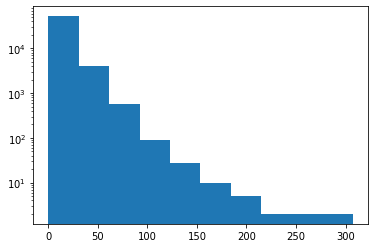

In [65]:
plt.hist(particles_train[:,:,0].flatten())
plt.yscale('log')

In [68]:
particles_train = normalize_features(particles_train)

Text(0.5, 1.0, 'normalized pt')

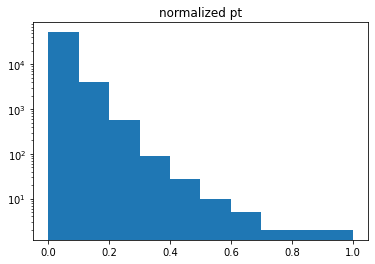

In [71]:
plt.hist(particles_train[:,:,0].flatten())
plt.yscale('log')
plt.title('normalized pt')

# build model: Autoencoder

In [72]:
gnn = grap.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 19, 4)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 19, 19)]     0                                            
__________________________________________________________________________________________________
graph_convolution_3 (GraphConvo (None, 19, 3)        12          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_4 (GraphConvo (None, 19, 2)        6           graph_convolution_3[0]

# train model

In [73]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)]
gnn.fit((particles_train, A_tilde), A, epochs=100, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
18/18 [==============================] - 0s 23ms/step - val_loss: 0.6810
Epoch 2/100
18/18 [==============================] - 0s 18ms/step - val_loss: 0.6797
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - val_loss: 0.6794
Epoch 4/100
18/18 [==============================] - 0s 17ms/step - val_loss: 0.6793
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - val_loss: 0.6792
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - val_loss: 0.6792
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - val_loss: 0.6792
Epoch 8/100
18/18 [==============================] - 0s 16ms/step - val_loss: 0.6791
Epoch 9/100
18/18 [==============================] - 0s 21ms/step - val_loss: 0.6791
Epoch 10/100
18/18 [==============================] - 0s 20ms/step - val_loss: 0.6791
Epoch 11/100
18/18 [==============================] - 0s 22ms/step - val_loss: 0.6790
Epoch 12/100
18/18 [==============================] - 0s 16ms/s

18/18 [==============================] - 0s 21ms/step - val_loss: 0.6789
Epoch 79/100
16/18 [=========================>....] - ETA: 0s
Epoch 00079: ReduceLROnPlateau reducing learning rate to 1.220703097715159e-06.
18/18 [==============================] - 0s 20ms/step - val_loss: 0.6789
Epoch 80/100
18/18 [==============================] - 0s 17ms/step - val_loss: 0.6789
Epoch 81/100
18/18 [==============================] - 0s 22ms/step - val_loss: 0.6789
Epoch 82/100
18/18 [==============================] - 0s 24ms/step - val_loss: 0.6789
Epoch 83/100
18/18 [==============================] - 0s 23ms/step - val_loss: 0.6789
Epoch 84/100
15/18 [========================>.....] - ETA: 0s
Epoch 00084: ReduceLROnPlateau reducing learning rate to 6.103515488575795e-07.
18/18 [==============================] - 0s 21ms/step - val_loss: 0.6789
Epoch 85/100
18/18 [==============================] - 0s 21ms/step - val_loss: 0.6789
Epoch 86/100
18/18 [==============================] - 0s 18ms/step 

# predict background

In [88]:
particles_test = particles[2000:3000]
A_test = make_adjacencies(particles_test)
A_tilde_test = normalized_adjacency(A_test)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


In [82]:
z, A_pred_probs = gnn((particles_test, A_tilde_test))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [83]:
A_pred = (A_pred_probs > 0.5).numpy().astype('int') 

In [86]:
loss_background = gnn.test_step(((particles_test, A_tilde_test), A_test))

In [87]:
loss_background

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.68007964>}

# load and predict signal

In [90]:
filename = '/home/kinga/dev/datasamples/L1_anomaly_challenge/hToTauTau_13TeV_PU20.h5'
ff = h5py.File(filename, 'r')
particles_signal = np.asarray(ff.get('Particles'))

In [91]:
particles_signal.shape

(691283, 19, 4)

In [92]:
# features: array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')
particles_signal_test = particles_signal[:3000]

In [93]:
A_signal = make_adjacencies(particles_signal_test)
A_tilde_signal = normalized_adjacency(A_signal)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


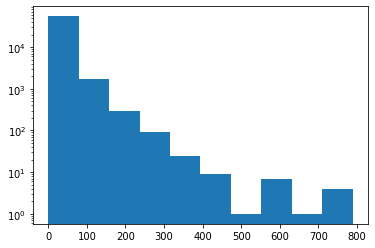

In [94]:
plt.hist(particles_signal_test[:,:,0].flatten())
plt.yscale('log')

In [95]:
particles_signal_test = normalize_features(particles_signal_test)

Text(0.5, 1.0, 'normalized pt')

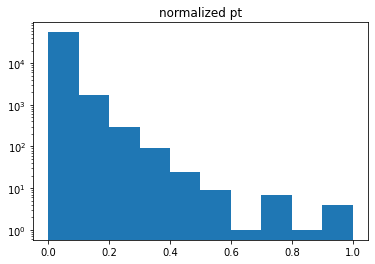

In [96]:
plt.hist(particles_signal_test[:,:,0].flatten())
plt.yscale('log')
plt.title('normalized pt')

In [98]:
z_signal, A_pred_probs_signal = gnn((particles_signal_test, A_tilde_signal))

In [99]:
A_pred_signal = (A_pred_probs_signal > 0.5).numpy().astype('int') 

In [100]:
loss_signal = gnn.test_step(((particles_signal_test, A_tilde_signal), A_signal))

In [101]:
loss_signal

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.64076227>}